<a href="https://colab.research.google.com/github/ramanakshay/Optimal-Transport/blob/main/notebooks/gradient_descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving OT using Neural Networks

## Import Libraries

In [1]:
# Download and import the MIT 6.S191 package
!pip install mitdeeplearning
import mitdeeplearning as mdl

# Import all remaining packages
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
!apt-get install abcmidi timidity > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 28.2 MB/s 
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.2.0-py3-none-any.whl size=2115442 sha256=775c52ef1467b36148d0c143c2361563b67564d083295edddc5ca0fccf46fb65
  Stored in directory: /root/.cache/pip/wheels/9a/b9/4f/99b7c8c5c75355550b83e1fcfc02956fb40c35eb01e2262877
Successfully built mitdeeplearning


In [2]:
!pip install pot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 664 kB 11.8 MB/s 


In [3]:
user = 'ramanakshay'
repo = 'Optimal-Transport'

url = f"git+https://github.com/{user}/{repo}.git"
!pip install --upgrade {url}

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/ramanakshay/Optimal-Transport.git to /tmp/pip-req-build-cit74_tn
  Running command git clone -q https://github.com/ramanakshay/Optimal-Transport.git /tmp/pip-req-build-cit74_tn
  Created wheel for utils: filename=utils-0.1.0-py3-none-any.whl size=3561 sha256=1bcf1ad70c96da72e90b8e9e280feca0507eb82a3242aad4cf2ad0ba4df92002
  Stored in directory: /tmp/pip-ephem-wheel-cache-aivnnm69/wheels/83/c1/b0/8b4aae55c1a6c852e5e98d2e522e0c76c069f92e4d3885455f
Successfully built utils


In [4]:
import tensorflow as tf

import ot  # ot
import ot.plot

import numpy as np
import matplotlib.pyplot as plt

In [194]:
from utils.plot import plot_matrix,plot_2d_map
from utils.dist import find_cost_tensor
from utils.data import gaussian_mix,dispersion_density,lorentzian,uniform_density

## Marginal

In [195]:
def dispersion_density(size,R):
  assert R <= 58*size/64  and R >= 0
  return gaussian_mix(size,[size//2 + R/2,size//2 - R/2],[size/32,size/32],[1,1.5])

In [197]:
n = 2
size = 100

a = gaussian_mix(size,[size/2],[size/8],[1])
#a = dispersion_density(size,60)
input_shape = a.shape

print('Input Shape:',input_shape)

x = np.array([[i,] for i in range(size)]) # defining the space
X = np.tile(x.T,(n,1))

Input Shape: (100,)


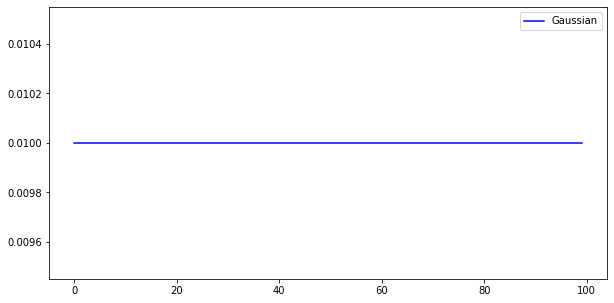

In [198]:
#Plot distribution
plt.figure(figsize=(10, 5))
plt.plot(x, a, 'b',label = 'Gaussian')
plt.legend()
plt.show()

## Cost Tensor

Cost Tensor: (100, 100)


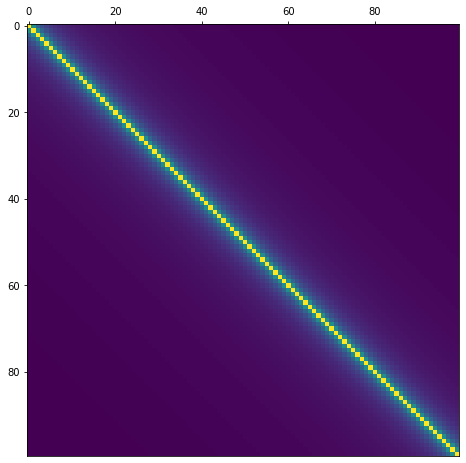

1.0


In [199]:
C = find_cost_tensor(X)
print('Cost Tensor:',C.shape)
plot_matrix(C,x,x)
print(C.max())

In [168]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense, Flatten

initializer = tf.keras.initializers.Zeros()

In [169]:
def build_model(input_shape,marginals):
  model = tf.keras.Sequential([
    #Dense(i, input_shape=input_shape, use_bias=False,activation = 'sigmoid',kernel_initializer=tf.keras.initializers.Zeros()), 
    #Dense(200,input_shape = input_shape,activation='softmax',kernel_initializer= initializer),
    Dense(200,input_shape = input_shape,activation='relu',kernel_initializer= initializer),
    Dense(size,input_shape = input_shape,kernel_initializer=initializer)
])
  return model

In [170]:
model = build_model(input_shape,n)

In [171]:
model.summary()

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_346 (Dense)           (None, 200)               20200     
                                                                 
 dense_347 (Dense)           (None, 100)               20100     
                                                                 
Total params: 40,300
Trainable params: 40,300
Non-trainable params: 0
_________________________________________________________________


In [185]:
def objective_entropy(f,epsilon):
  L = n*tf.math.reduce_sum(f*a)
  u = tf.math.exp(f/epsilon)
  P =  np.exp(-C/epsilon)
  for i in range(n):
    axes = [1,]*n
    axes[i] = size
    P *= tf.reshape(u,axes)
  L -= epsilon*tf.reduce_sum(P)
  return L

In [186]:
def objective_dual(f,ld):
  L = n*tf.math.reduce_sum(f*a)
  P = C
  for i in range(n):
    axes = [1,]*n
    axes[i] = size
    P -= tf.reshape(u,axes)
  L -= ld*tf.reduce_sum(P)
  return L

In [187]:
def plot_coupling(f):
  P =  np.exp(-C/epsilon)
  u = np.exp(f.numpy().T/epsilon)
  for i in range(n):
    axes = [1,]*n
    axes[i] = size
    axes = tuple(axes)
    P *= np.reshape(u,axes)

  #Pm = np.sum(P,axis = (2))
  plot_matrix(P,x,x)

In [188]:
epsilon = 1e-3
ld = 1e-2

In [189]:
### Hyperparameter setting and optimization ###

# Optimization parameters:
num_training_iterations = 1200
learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    learning_rate,
    decay_steps=2500,
    decay_rate=0.65,
    staircase=True)


In [190]:
from IPython.display import clear_output

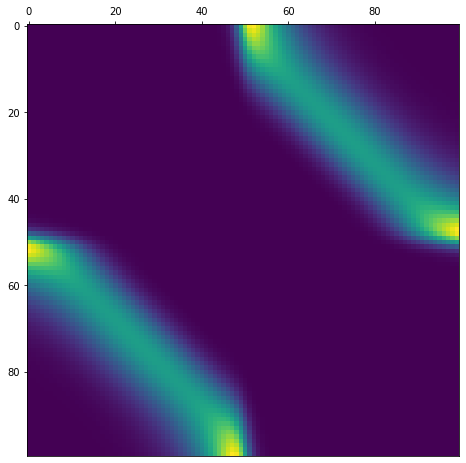

100%|██████████| 1200/1200 [00:36<00:00, 32.47it/s]


In [200]:
model = build_model(input_shape,n)

optimizer = tf.keras.optimizers.Adamax(learning_rate = lr_schedule)

@tf.function
def train_step(a):
  with tf.GradientTape() as tape:
    f = model(a)
    loss = -objective_entropy(f,epsilon)

  grads = tape.gradient(loss, model.trainable_variables)

  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss,f

history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):

  # Grab a batch and propagate it through the network
  loss,f = train_step(a.reshape(1,size))

  if (iter%(num_training_iterations//120) == 0):
    clear_output(wait=True)
    plot_coupling(f)
    
  # Update the progress bar
  #history.append(loss.numpy().mean())
  #plotter.plot(history)


tf.Tensor(0.011130902, shape=(), dtype=float32)


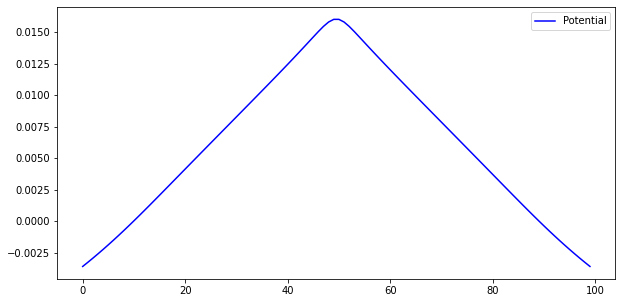

In [201]:
f = model(a.reshape(1,size))
# f = list(map(float,f.split()))
print()
x = np.array([[i,] for i in range(size)])
print(objective_entropy(f,epsilon))
#Plot distribution
plt.figure(figsize=(10, 5))
plt.plot(x, f.numpy().T, 'b',label = 'Potential')
plt.legend()
plt.show()

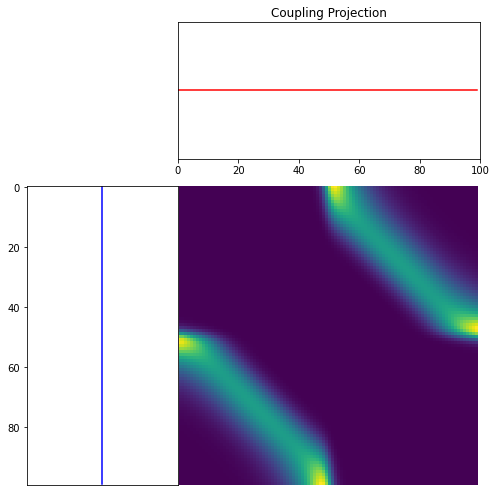

In [202]:
P =  np.exp(-C/epsilon)
u = np.exp(f.numpy().T/epsilon)
for i in range(n):
  axes = [1,]*n
  axes[i] = size
  axes = tuple(axes)
  P *= np.reshape(u,axes)

#Pm = np.sum(P,axis = (2))
plt.figure(figsize=(7, 7))
ot.plot.plot1D_mat(a, a, P, 'Coupling Projection')